In [15]:
# import the fun
%load_ext autoreload
%autoreload 2

import sys

sys.path.append('./tools')
sys.path.append('./data')

import numpy as np
from tqdm import tqdm
import math
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import Guided_Cond_DDPM_Tools as GC_DDPM

from sklearn.decomposition import PCA

import matplotlib.pyplot as plt

from HullParameterization import Hull_Parameterization as HP


np.set_printoptions(suppress=True) # don't use scientific notation

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:

#Step 1: Load in the data # the Design Paramaters Set
DesVec = np.load('./data/DesVec_82k.npy', allow_pickle=True)
print(DesVec.shape)
# print("DesVec 1: ", DesVec[0,:])
DesVec_neg = np.load('./data/Negative_DesVec_82k.npy', allow_pickle=True)
print(DesVec_neg.shape)
# print("DesVec_neg 1: ", DesVec_neg[0,:])

Peak_values = np.load('./data/peak_values.npy', allow_pickle=True)
# print("Peak values: ", Peak_values)

Rare_values = np.load('./data/rare_values.npy', allow_pickle=True)
# print("Rare values: ", Rare_values)

# Now lets clean up X

idx_BBFactors = [33,34,35,36,37]
idx_BB = 31

idx_SBFactors = [38,39,40,41,42,43,44]
idx_SB = 32

for i in range(0,len(DesVec)):
    
    DesVec[i,idx_BBFactors] = DesVec[i,idx_BB] * DesVec[i,idx_BBFactors] 
    DesVec[i,idx_SBFactors] = DesVec[i,idx_SB] * DesVec[i,idx_SBFactors]



Y = np.load('./data/GeometricMeasures.npy', allow_pickle=True) # 12 Geometry preporties 
print("Volume: ", Y.shape)

LenRatios = np.load('./data/Length_Ratios.npy', allow_pickle=True) 


X_LIMITS = np.load('./data/X_LIMITS.npy') # Range of each parameters

print(X_LIMITS.shape)

X_lower_lim = [X_LIMITS[:,0].tolist()]                   
X_upper_lim = [X_LIMITS[:,1].tolist()]



(82168, 45)
(82793, 44)
Volume:  (82168, 1010)
(44, 2)


In [17]:
#Set up Conditioning Vectors:
num_WL_Steps = 101

VolVec = np.log10(Y[:,1*num_WL_Steps:2*num_WL_Steps]) # volume 
idx = np.where(np.isnan(VolVec))
print(idx)

VolVec[idx] = -6.0 #fix nan to dummy value

print(VolVec.shape)

DdVec = DesVec[:,4] # Depth 
BOAVec = np.amax(LenRatios[:,1:3], axis=1) # Beam
print(BOAVec.shape) 

Cw = np.load('./data/Cw_82k.npy', allow_pickle=True)
print("Cw:", Cw.shape)
print("Cw 1: ", Cw[1])


(array([77257, 77257, 77257, 77257]), array([1, 2, 3, 4]))
(82168, 101)
(82168,)
Cw: (82168, 32)
Cw 1:  [5.33590573e-05 1.48241263e-04 4.73110005e-04 9.32835334e-04
 4.55477880e-03 2.73390696e-03 2.50265677e-03 3.27701191e-03
 6.35966207e-05 2.61060835e-04 7.58461305e-04 1.39558117e-03
 6.79105520e-03 3.70226242e-03 3.75574920e-03 5.15092304e-03
 6.09336130e-05 3.35627818e-04 1.14779314e-03 2.04508053e-03
 1.00218905e-02 4.84991400e-03 5.96316857e-03 8.89094546e-03
 7.10554086e-05 3.37943813e-04 1.06909708e-03 2.07395479e-03
 1.10484781e-02 5.16252732e-03 7.12133572e-03 1.17156953e-02]


C:\Users\24321\AppData\Local\Temp\ipykernel_2296\452437049.py:4: RuntimeWarning: invalid value encountered in log10
  VolVec = np.log10(Y[:,1*num_WL_Steps:2*num_WL_Steps]) # volume


In [ ]:
# Set up the file for architecting the network, diffusion parameters, and training

DDPM_C_Dict = {
        'xdim' : len(DesVec[0]) -1,             # Dimension of parametric design vector
        'datalength': len(DesVec),           # number of samples
        'X_LL' : X_lower_lim,           # lower limits of parametric design vector variables
        'X_UL' : X_upper_lim,
        'ydim': 0,                       # Number of objectives
        'cdim': 6,                      # number of conditioning inputs
        'gamma' : 0.7,                  # 0.2 weight of feasibility guidance for guided sampling
        'lambda': 0.7,                 # weight of drag  guidance for guided sampling
        'tdim': 128,                    # 128 dimension of latent variable
        'net': [512,512,512,512],   # network architecture
        'batch_size': 1024,             # batch size
        'Training_Epochs': 10000,      # number of training epochs
        'Diffusion_Timesteps': 1000,    # number of diffusion timesteps
        'lr' : 0.00025,                 # learning rate
        'weight_decay': 0.0,            # weight decay  
        'device_name': 'cuda:0'}        # gpu device name

Classify_Dict = {
        'xdim' : len(DesVec[0])-1,
        'cdim': 1,
        'tdim': 128,
        'net': [64,64,64],
        'Training_Epochs': 150000,
        'device_name': 'cuda:0'}

nodes = 512
Drag_Reg_Dict = {
        'xdim' : len(DesVec[0])-1,              # Dimension of parametric design vector
        'ydim': 1,                              # trains regression model for each objective
        'tdim': nodes,                            # dimension of latent variable
        'net': [nodes,nodes,nodes,nodes],                       # network architecture        
        'Training_Epochs': 30000,  #30000             # number of training epochs
        'batch_size': 1024,                       # batch size
        'Model_Label': 'Regressor_CT',         # labels for regressors       
        'lr' : 0.001,                          # learning rate
        'weight_decay': 0.0,                   # weight decay
        'device_name': 'cuda:0'} 

nodes = 256
LOA_wBulb_Reg_Dict = {
        'xdim' : len(DesVec[0])-1,              # Dimension of parametric design vector
        'ydim': 1,                              # trains regression model for each objective
        'tdim': nodes,                            # dimension of latent variable
        'net': [nodes,nodes,nodes],                       # network architecture        
        'Training_Epochs': 150000,               # number of training epochs
        'batch_size': 1024,                       # batch size
        'Model_Label': 'Regressor_LOA_wBulb',         # labels for regressors
                    
        'lr' : 0.001,                          # learning rate
        'weight_decay': 0.0,                   # weight decay
        'device_name': 'cuda:0'}   

WL_Reg_Dict = {
        "xdim": len(DesVec[0]),
        "ydim": 1, 
        "tdim": 512, 
        "net": [512, 512, 512], 
        "Training_Epochs": 30000, 
        "batch_size": 1024, 
        "Model_Label": 
        "Regressor_WL", 
        "lr": 0.001, 
        "weight_decay": 0.0, 
        "device_name": "cuda:0"}

Vol_Reg_Dict = {
                "xdim": len(DesVec[0]), 
                "ydim": 1, 
                "tdim": 512, 
                "net": [512, 512, 512], 
                "Training_Epochs": 30000, 
                "batch_size": 1024, 
                "Model_Label": "Regressor_WL", 
                "lr": 0.001, 
                "weight_decay": 0.0, 
                "device_name": "cuda:0"}

T2 = GC_DDPM.GuidedDiffusionEnv(DDPM_C_Dict,
                Classify_Dict,
                Drag_Reg_Dict,
                LOA_wBulb_Reg_Dict,
                WL_Reg_Dict,
                Vol_Reg_Dict,
                X= DesVec[:,1:],
                X_neg= DesVec_neg,
                VolVec = VolVec, 
                BOAVec = BOAVec, 
                DdVec = DdVec,
                Cw = Cw)

In [19]:
'''
===================================================
train classifier
===================================================
'''
# '''
# T2.run_train_classifier_loop(batches_per_epoch=1)

# PATH =  './TrainedModels/'

# name = 'Constraint_Classifier' +'_'+ str(Classify_Dict['Training_Epochs']) + 'Epochs'

# T2.Save_classifier_model(PATH, name)

# '''
classifier_path = './TrainedModels/Constraint_Classifier_150000Epochs.pth' 

T2.load_trained_classifier_model(classifier_path)


In [20]:
'''
===================================================
Load Regression Models
==================================================
'''
PATHS = ['./TrainedModels/Regressor_CT.pth',
        './TrainedModels/Regressor_LOA_wBulb.pth',
        './TrainedModels/Regressor_WL.pth',
        './TrainedModels/Regressor_Vol.pth']
#LOA_Reg_Path = './TrainedModels/Regressor_LOA_wBulb.pth'

T2.load_trained_Drag_regression_models(PATHS)

In [21]:
# '''
# ================================================
# train conditional diffusion model (wavedrag)
# ==================================================
# '''
# '''

# T2.run_train_diffusion_loop(batches_per_epoch=1)

# PATH =  './TrainedModels/'

# name = 'CShipGen_Cw'


# T2.Save_diffusion_model(PATH, name)


# '''
                   
diffusion_cw_path = './TrainedModels/CShipGen_Cw_8M_BD_diffusion.pth'
T2.load_trained_diffusion_model(diffusion_cw_path)

Visulization of the training loos: 

In [22]:
# plt.plot(T2.loss_history[:,0],T2.loss_history[:,1], label = 'Loss')
# plt.title("Loss")
# plt.xlabel("Iterations")
# plt.ylabel("Loss value")
# plt.legend()
# plt.grid(True)
# plt.show()

In [23]:
#Sample from the Model:
num_samples = 512

In [24]:
# Wave drag condtion 
Ships = np.array([[333, 42.624, 11.28, 29.064, 0.0003, 0.43], #Nimitz Class Carrier [LOA(m), BOA(m), T(m), Dd(m), Ct, Fn] Ct: 0.003826
                  ])

Labels = ['333', 'Kayak', 'Neo-Panamax Container Ship', 'NSC', 'ROPAX ferry']

In [25]:
# Run the Loop on the other samples:
Study_Label = 'Study_' + str(0) + '_' + Labels[0] + '_CT_' + str(Ships[0, 4]) + '_Fn_' + str(Ships[0, 5])

print('Generating Hulls')

LOA = Ships[0,0] #in meters
BoL = Ships[0,1]/LOA #beam to length ratio
ToD = Ships[0,2]/Ships[0,3] #Draft to depth ratio
DoL = Ships[0,3]/LOA #Depth to length ratio
Ct = Ships[0, 4] # Wave drag coefficient

Fn = Ships[0,5]  #  12.86 #m/s  = 25 knots

dim_d = np.array([[ToD, Fn, LOA, Ct, DoL, BoL]]) #Drag_conditioning is [ToD, Fn(m/s), LOA (m), Ct]
# num_sample = 512
drag_cond = np.repeat(dim_d, num_samples, axis=0) #reapeat 512 
#print(cond.shape)

# dim_g = np.array([[ToD, BoL, DoL, Ct]])            # Condition Vector
print('Condition: ',drag_cond.shape )

# Parameters of known design (44 parameters, LOA given in CshipGen)

x_gt = torch.tensor([4.96634266e-01  ,4.51955760e-01  ,BoL,
8.75783026e-02,  5.71478128e-01,  1.43758851e-01,  1.31093639e-01,
   DoL,  3.16418976e-01, -3.14146566e-01,  3.54170799e-01,
4.29022789e-01,  1.32593811e-01,  6.56113803e-01,  1.69787741e+00,
-1.84923196e+00,  3.88996124e-01, -3.26323986e-01,  1.01175034e+01,
0.00000000e+00,  0.00000000e+00, -2.73985386e-01,  4.10849154e-01,
2.80871749e-01, -2.13681006e+00,  1.77291155e+00,  1.66059315e+00,
7.07736760e-02,  4.26586211e-01,  2.07895815e-01,  0.00000000e+00,
0.00000000e+00,  0.00000000e+00,  0.00000000e+00 , 0.00000000e+00,
0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
0.00000000e+00]).to('cuda:0')


# value with highest frequency
# x_gt = torch.tensor(Peak_values[1:]).to('cuda:0')

# # value with Lowest frequency
# x_gt = torch.tensor(Rare_values[1:]).to('cuda:0')

#----------------------------------
# print('GT: ', x_gt)
# Mask configuration
# 0-6 :Principle Dimensions 
# 7-10: Midship Cross Section 
# 11-19: Bow Geometry 
# 20-30: Stern Geometry 
# 31-44: Bulb Geometries
#----------------------------------

keep_mask = torch.zeros(x_gt.shape).to('cuda:0')
# keep_mask[0:1] = 1
keep_mask[6] = 1
Enable_mask = 1

# print("mask:", keep_mask)
# print("temp: ", x_gt*keep_mask)

# normalization:
x_gt_unorm = x_gt
x_gt =x_gt.cpu().numpy()
x_gt = x = 2.0*(x_gt-T2.data_norm.X_LL_Scaled)/(T2.data_norm.X_UL_Scaled- T2.data_norm.X_LL_Scaled) - 1.0
x_gt = T2.data_norm.normalizer.transform(x)
# print("x_gt_norm: ",x_gt)
x_gt = torch.from_numpy(x_gt.astype('float32')).to('cuda:0')


# Gen Samples:
print("Gen-no-guidance: ")
X_gen_cond, unnorm_cond_only = T2.gen_cond_samples(drag_cond, x_gt = x_gt, keep_mask = keep_mask, Repaint = Enable_mask)

print("Gen-guidance: ")
X_gen, unnorm = T2.gen_low_drag_samples(drag_cond, x_gt = x_gt, keep_mask = keep_mask, Repaint = Enable_mask) 

print(X_gen_cond.shape)


Generating Hulls
Condition:  (512, 6)
Gen-no-guidance: 
x_gt_norm: tensor([[ 1.2221,  0.2040, -1.2101, -0.4625,  0.5554, -1.3666, -1.0248, -1.1171,
         -0.5738, -0.8898, -0.0521,  0.4763, -1.6564,  0.9001,  0.8141, -0.8258,
          0.1435, -0.2286, -1.6559, -5.1993, -5.1993,  0.0406, -0.6278, -1.2824,
         -1.0300,  0.7681, -2.0514, -0.0612,  1.6653,  1.0643, -5.1993, -5.1993,
         -5.1993, -5.1993, -5.1993, -0.0088, -5.1993, -5.1993, -5.1993, -5.1993,
         -5.1993, -5.1993, -0.0213, -5.1993]], device='cuda:0')


100%|██████████| 999/999 [00:39<00:00, 25.19it/s]


Gen-guidance: 


100%|██████████| 32/32 [00:01<00:00, 25.91it/s]

(512, 44)


In [26]:
print("LOA: ", LOA)
print("X_shape:", unnorm.shape)

UorF = 1 # Use Fn as condition or not 
print("condition: ", dim_d[0])
Rt_guidance, CT = T2.Predict_Drag(unnorm, drag_cond, UorF = UorF)    # Drag_conditioning is [ToD, Fn(m/s), LOA (m), Ct]
Drag_Guidance = np.mean(Rt_guidance)
Ct_mean = np.mean(CT)

Rt_no_guidance, CT_no = T2.Predict_Drag(unnorm_cond_only, drag_cond, UorF = UorF)    # Drag_conditioning is [ToD, Fn(m/s), LOA (m), Ct]
Drag_no_Guidance = np.mean(Rt_no_guidance)
Ct_no_mean = np.mean(CT_no)

print('-----------------------------------------------------')
print('Predicted Mean Drag Coefficient Ct of Guidance samples:', Ct_mean)
print('Predicted Mean Drag of Guidance samples: ' + str(Drag_Guidance) + ' N')
print('Minimum Drag of Guidance samples: ' + str(np.amin(Rt_guidance)) + ' N')
print('-----------------------------------------------------')
print('Predicted Mean Drag Coefficient Ct of no Guidance samples:', Ct_no_mean)
print('Predicted Mean Drag of no Guidance samples: ' + str(Drag_no_Guidance) + ' N')
print('Minimum Drag of no Guidance samples: ' + str(np.amin(Rt_no_guidance)) + ' N')

LOA:  333.0
X_shape: (512, 44)
condition:  [3.88109001e-01 4.30000000e-01 3.33000000e+02 3.00000000e-04
 8.72792793e-02 1.28000000e-01]
-----------------------------------------------------
Predicted Mean Drag Coefficient Ct of Guidance samples: 0.00028385778
Predicted Mean Drag of Guidance samples: 9321760.0 N
Minimum Drag of Guidance samples: 8337946.5 N
-----------------------------------------------------
Predicted Mean Drag Coefficient Ct of no Guidance samples: 0.00028468692
Predicted Mean Drag of no Guidance samples: 9339336.0 N
Minimum Drag of no Guidance samples: 8268152.0 N


In [27]:
print('Checking Feasibility of Samples')

x_samples = X_gen
LOAs = np.repeat(LOA , x_samples.shape[0])
x_samples = np.hstack((LOAs[:,np.newaxis], x_samples))

for i in range(0,len(x_samples)):
    
    x_samples[i,idx_BB] = (x_samples[i,idx_BB] + 0.5) // 1 #int rounds to 1 or 0
    x_samples[i,idx_SB] = (x_samples[i,idx_SB] + 0.5) // 1 #int rounds to 1 or 0
    
    
    x_samples[i,idx_BBFactors] = x_samples[i,idx_BB] * x_samples[i,idx_BBFactors] 
    x_samples[i,idx_SBFactors] = x_samples[i,idx_SB] * x_samples[i,idx_SBFactors]

#Check the constraint violations for the sampled designs
constraints = []
sum_violation = []
cons = []
valid_idx = []
# check guidance result
for i in tqdm(range(0,len(x_samples))):
    hull = HP(x_samples[i])
    constraints.append(hull.input_Constraints())
    cons.append(constraints[i] > 0)
    if sum(cons[i]) == 0:
        valid_idx.append(i)
        #hull.Calc_VolumeProperties(NUM_WL = 101, PointsPerWL = 1000)
    sum_violation.append(sum(cons[i]))

print("Fesible design with guidance: ", len(valid_idx))

# Calculate the BOA and Dd / under guidance 
sample_BOA = []
sample_Dd = []
idx_to_remove = []

for i in tqdm(range(0,len(valid_idx))): # calculate the performance of the generated samples 
    hull = HP(x_samples[valid_idx[i]]) 
    # print(i)
    try:
        Z = hull.Calc_VolumeProperties(NUM_WL = 101, PointsPerWL = 1000)
        BOA = max(hull.Calc_Max_Beam_midship(), hull.Calc_Max_Beam_PC())
        sample_BOA.append(BOA)
        sample_Dd.append(hull.Dd)
    except:
        print('error at hull {}'.format(i))
        idx_to_remove.append(i)
        continue

#Remove the samples that failed to calculate volume properties
valid_idx = np.delete(valid_idx, idx_to_remove)
print(len(valid_idx))

x_samples = X_gen_cond
LOAs = np.repeat(LOA , x_samples.shape[0])
x_samples = np.hstack((LOAs[:,np.newaxis], x_samples))

for i in range(0,len(x_samples)):
    
    x_samples[i,idx_BB] = (x_samples[i,idx_BB] + 0.5) // 1 #int rounds to 1 or 0
    x_samples[i,idx_SB] = (x_samples[i,idx_SB] + 0.5) // 1 #int rounds to 1 or 0
    
    
    x_samples[i,idx_BBFactors] = x_samples[i,idx_BB] * x_samples[i,idx_BBFactors] 
    x_samples[i,idx_SBFactors] = x_samples[i,idx_SB] * x_samples[i,idx_SBFactors]

#Check the constraint violations for the sampled designs
constraints_1 = []
sum_violation_1 = []
cons_1 = []
valid_idx_1 = []
# check guidance result
for i in tqdm(range(0,len(x_samples))):
    hull = HP(x_samples[i])
    constraints_1.append(hull.input_Constraints())
    cons_1.append(constraints_1[i] > 0)
    if sum(cons_1[i]) == 0:
        valid_idx_1.append(i)
        #hull.Calc_VolumeProperties(NUM_WL = 101, PointsPerWL = 1000)
    sum_violation_1.append(sum(cons_1[i]))

print("Fesible design with no guidance: ", len(valid_idx_1))

# Calculate the BOA and Dd / without guidance 
sample_BOA_ng = []
sample_Dd_ng = []
idx_to_remove_ng = []

for i in tqdm(range(0,len(valid_idx_1))): # calculate the performance of the generated samples 
    hull = HP(x_samples[valid_idx_1[i]]) 
    # print(i)
    try:
        Z = hull.Calc_VolumeProperties(NUM_WL = 101, PointsPerWL = 1000)
        BOA = max(hull.Calc_Max_Beam_midship(), hull.Calc_Max_Beam_PC())
        sample_BOA_ng.append(BOA)
        sample_Dd_ng.append(hull.Dd)
    except:
        print('error at hull {}'.format(i))
        idx_to_remove_ng.append(i)
        continue

#Remove the samples that failed to calculate volume properties
valid_idx_1 = np.delete(valid_idx_1, idx_to_remove_ng)
print(len(valid_idx_1)) 

Checking Feasibility of Samples


100%|██████████| 512/512 [00:00<00:00, 10771.24it/s]


Fesible design with guidance:  512


100%|██████████| 512/512 [03:40<00:00,  2.33it/s]


512


100%|██████████| 512/512 [00:00<00:00, 10042.15it/s]


Fesible design with no guidance:  512


100%|██████████| 512/512 [03:39<00:00,  2.34it/s]

512


In [29]:
# np.save('./result/' + Study_Label + '_Conditioning_Only_RT_DesVec.npy',X_gen_cond[valid_idx_1])
# np.save('./result/' + Study_Label + '_Drag_Guidance_DesVec.npy',X_gen[valid_idx])
# np.save('./result/' + Study_Label + '_Rt_pred.npy',Rt_guidance[valid_idx])

# The error of result under guidance
print('Caclculating Error in Samples:')

sample_RT = Rt_guidance[valid_idx]
sample_Ct = CT[valid_idx]
sample_BOA = np.array(sample_BOA)   # Beam 
sample_Dd = np.array(sample_Dd)     # Depth

CTMAPE = np.mean(np.abs(sample_Ct - Ships[0,4])/sample_Ct)*100
print('CT with guidance MAPE: {}%'.format(CTMAPE))

BOAMEAP = np.mean(np.abs(sample_BOA - Ships[0,1])/Ships[0,1])*100
print('Beam MEAP: {}%'.format(BOAMEAP))

DdMEAP = np.mean(np.abs(sample_Dd - Ships[0,3])/Ships[0,3])*100
print('Depth MEAP: {}%'.format(DdMEAP))

# The error of result under condition only and no guidance
sample_RT = Rt_no_guidance[valid_idx_1]
sample_no_Ct = CT_no[valid_idx_1]
sample_BOA = np.array(sample_BOA_ng)   # Beam 
sample_Dd = np.array(sample_Dd_ng)     # Depth
CTMAPE = np.mean(np.abs(sample_no_Ct - Ships[0,4])/sample_no_Ct)*100
print('CT without guidance MAPE: {}%'.format(CTMAPE))

BOAMEAP = np.mean(np.abs(sample_BOA - Ships[0,1])/Ships[0,1])*100
print('Beam MEAP: {}%'.format(BOAMEAP))

DdMEAP = np.mean(np.abs(sample_Dd - Ships[0,3])/Ships[0,3])*100
print('Depth MEAP: {}%'.format(DdMEAP))



Caclculating Error in Samples:
CT with guidance MAPE: 6.073437584274797%
Beam MEAP: 1.0939675256484507%
Depth MEAP: 0.4609230315090871%
CT without guidance MAPE: 5.790587604562743%
Beam MEAP: 1.1089672840668696%
Depth MEAP: 0.4300848430643224%


Expect value:  0.0003
Mean of Ct with guidance:  0.00028385778
Variance of Ct with guidance:  1.2191043e-10
Error to expect value:  1.6142221586778734e-05
Mean of Ct without guidance:  0.00028468692
Variance of Ct without guidance:  1.1670456e-10
Error to expect value:  1.5313082560896847e-05


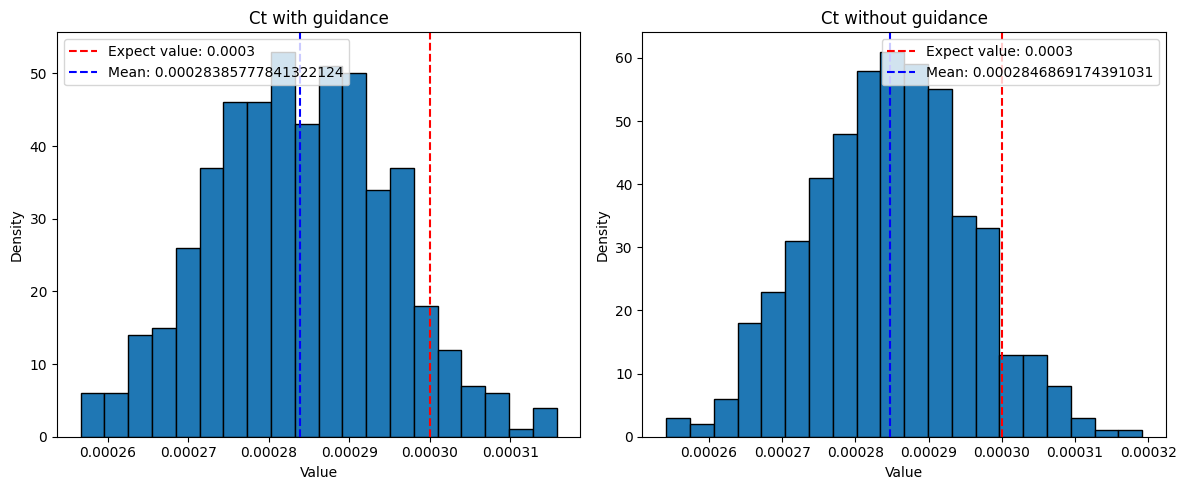

In [30]:
bin_num = 20
fig, axs = plt.subplots(1, 2, figsize=(12, 5)) 
counts, edges = np.histogram(sample_Ct, bins=bin_num)
print("Expect value: ", Ct )
print("Mean of Ct with guidance: ",np.mean(sample_Ct))
print("Variance of Ct with guidance: ", np.var(CT))
print("Error to expect value: ", np.abs(Ct - np.mean(sample_Ct)) )

counts_2, edges_2 = np.histogram(CT_no, bins = bin_num)
print("Mean of Ct without guidance: ", np.mean(CT_no))
print("Variance of Ct without guidance: ", np.var(CT_no))
print("Error to expect value: ", np.abs(Ct - Ct_no_mean) )

axs[0].bar(edges[:-1], counts, width=np.diff(edges), edgecolor='black', align='edge')
axs[0].axvline(x=Ct, color='red', linestyle='--', label=f'Expect value: {Ct}')
axs[0].axvline(x=np.mean(sample_Ct), color='blue', linestyle='--', label=f'Mean: {Ct_mean}')
axs[0].set_title('Ct with guidance')
axs[0].set_xlabel('Value')
axs[0].set_ylabel('Density')
axs[0].legend()

axs[1].bar(edges_2[:-1], counts_2, width=np.diff(edges_2), edgecolor='black', align='edge')
axs[1].axvline(x=Ct, color='red', linestyle='--', label=f'Expect value: {Ct}')
axs[1].axvline(x=np.mean(CT_no), color='blue', linestyle='--', label=f'Mean: {Ct_no_mean}')
axs[1].set_title('Ct without guidance')
axs[1].set_xlabel('Value')
axs[1].set_ylabel('Density')
axs[1].legend()

plt.tight_layout()
plt.show()

Expect value:  0.0003
Mean value:  0.00028385778


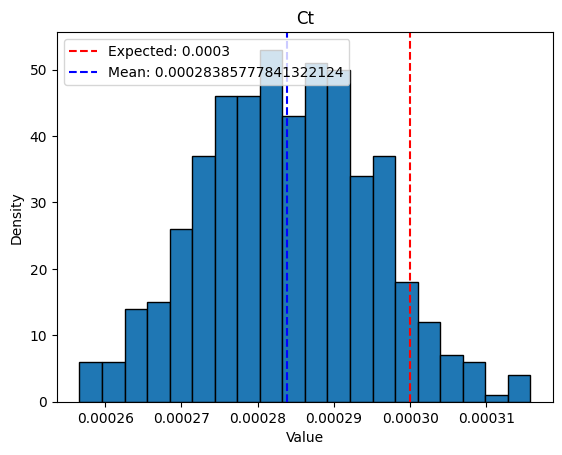

In [31]:
counts, edges = np.histogram(sample_Ct, bins = 20)
print("Expect value: ", Ct)
print("Mean value: ", np.mean(CT))
plt.bar(edges[:-1], counts, width=np.diff(edges), edgecolor='black', align='edge')
plt.axvline(x=Ct, color='red', linestyle='--', label=f'Expected: {Ct}')
plt.axvline(np.mean(sample_Ct), color='blue', linestyle='--', label=f'Mean: {np.mean(sample_Ct)}')
plt.legend()
plt.title("Ct")
plt.xlabel("Value")
plt.ylabel("Density")
plt.show()

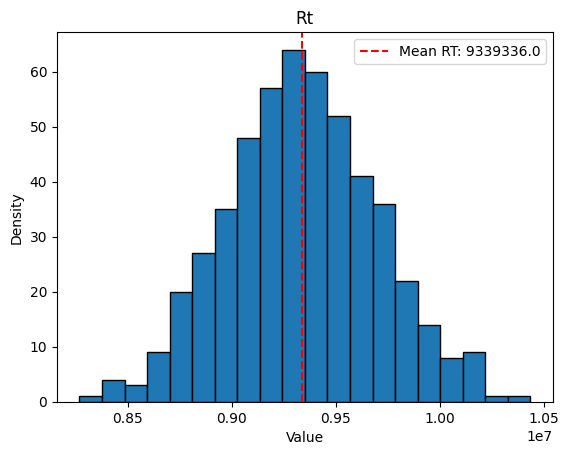

In [32]:
counts, edges = np.histogram(sample_RT, bins=20)

plt.bar(edges[:-1], counts, width=np.diff(edges), edgecolor='black', align='edge')
plt.axvline(x=np.mean(sample_RT), color='red', linestyle='--', label=f'Mean RT: {np.mean(sample_RT)}')
plt.legend()
plt.title("Rt")
plt.xlabel("Value")
plt.ylabel("Density")
plt.show()
# print(sample_RT)

In [33]:
# print(unnorm_cond_only[1:3])
print("unnormalized generated result",unnorm_cond_only[1:2]*keep_mask.cpu().numpy())
print("normalized generated result",X_gen_cond[1:2]*keep_mask.cpu().numpy())
print("x_gt_unorm: ", x_gt_unorm*keep_mask)
# print(X_gen_cond[1:2]*keep_mask.cpu().numpy())
# print("R: ",Rare_values)
# print("R: ",Rare_values[8:9])
print("gt: ", x_gt*keep_mask)
# print("gt: ", x_gt[7:11])


unnormalized generated result [[ 0.        -0.        -0.        -0.         0.        -0.
  -1.0248345  0.         0.        -0.         0.        -0.
  -0.        -0.         0.        -0.         0.        -0.
  -0.        -0.         0.        -0.         0.         0.
  -0.        -0.         0.        -0.         0.        -0.
  -0.        -0.        -0.        -0.        -0.         0.
  -0.        -0.        -0.        -0.        -0.        -0.
  -0.        -0.       ]]
normalized generated result [[ 0.          0.          0.          0.          0.          0.
   0.13109364  0.          0.         -0.          0.         -0.
   0.          0.          0.         -0.          0.         -0.
   0.          0.          0.         -0.          0.          0.
  -0.          0.          0.          0.          0.         -0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.        ]]